In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 启用交互式绘图模式
%matplotlib notebook

In [2]:
x = np.linspace(0,100,50)
y = np.linspace(100,0,50)

In [3]:
x_grid,y_grid = np.meshgrid(x,y)

In [4]:
def fun(x,y):
    return x + 0.5*y+ 50*np.sin(x/20) + ((x-50)/50)*(y-50)

In [5]:
# 计算每个自变量组合对应的因变量值
result_grid = fun(x_grid, y_grid)

In [6]:
data_list = []
for i in x:
    for j in y:
        data_list.append([i,j,fun(i,j)])
data_list = np.array(data_list)

<IPython.core.display.Javascript object>


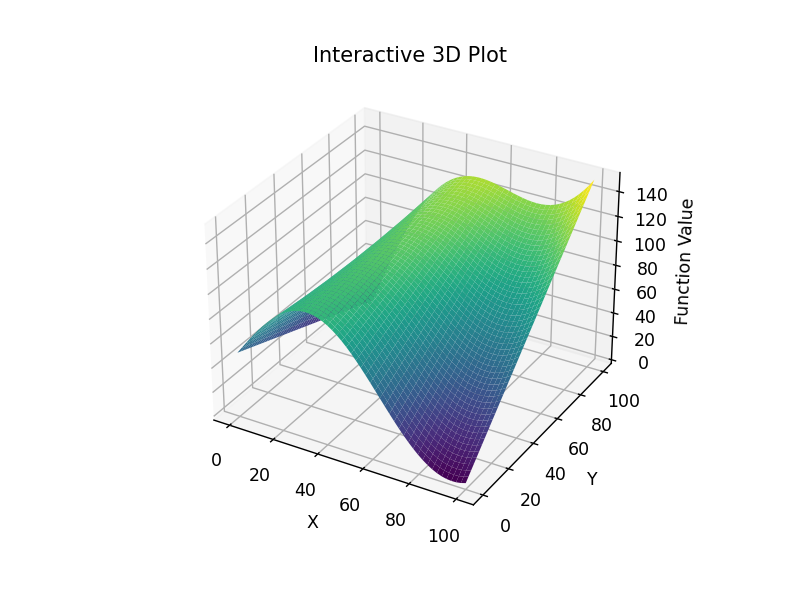

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, result_grid, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Function Value')
plt.title('Interactive 3D Plot')
plt.show()

# 生成标准化数据

In [8]:
data_list = []
for i in x:
    for j in y:
        data_list.append([i,j,fun(i,j)])
data_list = np.array(data_list)

In [12]:
data = data_list[:,:2]
label = data_list[:,-1]

In [14]:
normal_data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))
normal_label = (label - label.min())/(label.max()-label.min())

In [21]:
normal_data[:,0].max()

1.0

# 使用GAN生成数据

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

In [24]:
data.shape

(2500, 2)

In [25]:
# 设定随机种子以保证可重复性
torch.manual_seed(42)

# 定义生成器和判别器网络
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# 定义 GAN 类
class GAN:
    def __init__(self, input_dim, output_dim, lr_g=0.0002, lr_d=0.0002):
        self.generator = Generator(input_dim, output_dim)
        self.discriminator = Discriminator(output_dim)
        self.criterion = nn.BCELoss()
        self.optimizer_g = optim.Adam(self.generator.parameters(), lr=lr_g)
        self.optimizer_d = optim.Adam(self.discriminator.parameters(), lr=lr_d)
    
    def train(self, data, num_epochs=10000, batch_size=64):
        for epoch in range(num_epochs):
            for _ in range(1):  # 更新判别器多次
                self.discriminator.zero_grad()
                real_labels = torch.ones(batch_size, 1)
                fake_labels = torch.zeros(batch_size, 1)
                real_data = torch.tensor(data[np.random.choice(data.shape[0], batch_size)])
                fake_data = self.generator(torch.randn(batch_size, 2))
                
                real_outputs = self.discriminator(real_data)
                fake_outputs = self.discriminator(fake_data.detach())
                
                loss_real = self.criterion(real_outputs, real_labels)
                loss_fake = self.criterion(fake_outputs, fake_labels)
                loss_d = loss_real + loss_fake
                loss_d.backward()
                self.optimizer_d.step()
            
            self.generator.zero_grad()
            fake_data = self.generator(torch.randn(batch_size, 2))
            fake_outputs = self.discriminator(fake_data)
            loss_g = self.criterion(fake_outputs, real_labels)
            loss_g.backward()
            self.optimizer_g.step()

            if epoch % 100 == 0:
                print(f"Epoch [{epoch}/{num_epochs}], Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}")

    def generate(self, num_samples=2500):
        with torch.no_grad():
            samples = self.generator(torch.randn(num_samples, 2))
        return samples.numpy()


In [ ]:
# 准备数据
data = data
input_dim = data.shape[1]

# 创建 GAN 模型并进行训练
gan = GAN(input_dim, output_dim=input_dim)
gan.train(data)

# 生成数据
generated_data = gan.generate()

# 绘制原始数据和生成数据的分布
plt.scatter(data[:, 0], data[:, 1], label='Real Data')
plt.scatter(generated_data[:, 0], generated_data[:, 1], label='Generated Data')
plt.legend()
plt.title('Real Data vs Generated Data')
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# 设定随机种子以保证可重复性
torch.manual_seed(42)

# 定义生成器和判别器网络
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Tanh()  # 使用 Tanh 激活函数来限制输出在 [-1, 1] 范围内
        )
    
    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# 定义 CGAN 类
class CGAN:
    def __init__(self, input_dim, output_dim, label_dim, lr_g=0.0002, lr_d=0.0002):
        self.generator = Generator(input_dim + label_dim, output_dim)
        self.discriminator = Discriminator(output_dim + label_dim)
        self.criterion = nn.BCELoss()
        self.optimizer_g = optim.Adam(self.generator.parameters(), lr=lr_g)
        self.optimizer_d = optim.Adam(self.discriminator.parameters(), lr=lr_d)
    
    def train(self, dataloader, num_epochs=10000):
        for epoch in range(num_epochs):
            for real_data, labels in dataloader:
                batch_size = real_data.size(0)
                self.discriminator.zero_grad()
                real_labels = torch.ones(batch_size, 1)
                fake_labels = torch.zeros(batch_size, 1)
                real_labels_data = torch.cat([real_data, labels], dim=1)
                fake_data = self.generator(torch.cat([torch.randn(batch_size, 2), labels], dim=1))
                fake_labels_data = torch.cat([fake_data.detach(), labels], dim=1)
                
                real_outputs = self.discriminator(real_labels_data)
                fake_outputs = self.discriminator(fake_labels_data)
                
                loss_real = self.criterion(real_outputs, real_labels)
                loss_fake = self.criterion(fake_outputs, fake_labels)
                loss_d = loss_real + loss_fake
                loss_d.backward()
                self.optimizer_d.step()
            
                self.generator.zero_grad()
                fake_data = self.generator(torch.cat([torch.randn(batch_size, 2), labels], dim=1))
                fake_labels_data = torch.cat([fake_data, labels], dim=1)
                fake_outputs = self.discriminator(fake_labels_data)
                loss_g = self.criterion(fake_outputs, real_labels)
                loss_g.backward()
                self.optimizer_g.step()

            if epoch % 100 == 0:
                print(f"Epoch [{epoch}/{num_epochs}], Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}")

    def generate(self, num_samples=100, labels=None):
        if labels is None:
            labels = torch.randint(0, 10, (num_samples, 1), dtype=torch.float32)  # 随机生成标签
        with torch.no_grad():
            generated_data = self.generator(torch.cat([torch.randn(num_samples, 2), labels], dim=1))
        return generated_data, labels

# 准备 MNIST 数据集
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # 归一化到 [-1, 1] 范围
])

train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 创建 CGAN 模型并进行训练
input_dim = 2
output_dim = 28 * 28  # 图像大小为 28x28
label_dim = 1  # 标签维度为1
cgan = CGAN(input_dim, output_dim=output_dim, label_dim=label_dim)
cgan.train(dataloader)

# 生成数据并可视化
generated_data, generated_labels = cgan.generate(num_samples=100)
generated_data = generated_data.view(-1, 1, 28, 28)  # 转换为图像格式

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        axes[i, j].imshow(generated_data[i * 10 + j][0].cpu(), cmap='gray')
        axes[i, j].axis('off')
plt.show()
